# Lecture 24 - Data Analysis via Least-Squares Fitting 

## Overview, Objectives, and Key Terms
 
A ubiquitous task in engineering and other technical disciplines is the analysis of data.  Data comes from many sources, including measurements in the laboratory and numerical simulations.  In this lecture and in [Lecture 25](), we'll apply what we've learned so far to produce *models* from data that we can use to explore trends and make conclusions.  Specifically, in this lecture, we'll develop models based on **least-squares** fitting of model parameters to existing data.


### Objectives

By the end of this lesson, you should be able to

- Explain (and demonstrate) what is meant by a least-squares fit of a linear model $ax+b$ to a set of measured points $(x_i, y_i),\, i = 0, 1, \ldots$.
- Use built-in tools to perform linear, least-squares fitting of data to models
- Use built-in tools to perform nonlinear, least-squares fitting of data to models

### Key Terms

- error
- least-squares
- normal equation
- `np.linalg.solve`
- `np.polyfit`
- `np.polyval`
- `scipy.optimize.curve_fit`


## Noisy Data and $y = at + b$

We'll start simple and explore a task with which most students ought to be familiar: running a line through some scattered points of the form $y = at+b$ through several, scattered points $(t_i, y_i),\, i = 0, 1, \ldots$.   To illustrate the problem, suppose a number of measurements $y_i$ were taken at evenly spaced times $t_0, t_1, \ldots$, as show below.

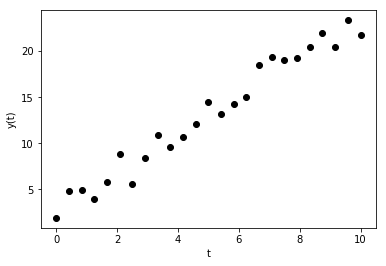

In [1]:
from data_fitting_examples import scattered_points
t, y = scattered_points()

We'll *assume* that the observed quantity $y(t)$ varies *linearly* with $t$, i.e., we define $y(t) = at + b$.  The goal is to find the model parameters $a$ and $b$ yielding a model that *best* matches the observed values $y_i$.  

Before defining what exactly *best* means, try to define $a$ and $b$ by inspection.  One easy way to estimate $a$ and $b$ is to use the first and last measured points, i.e., defined the intercept to be $b = y[0]$ and the slope to be $a = (y[-1]-y[0])/(t[-1]-t[0])$.  

The result is not bad:

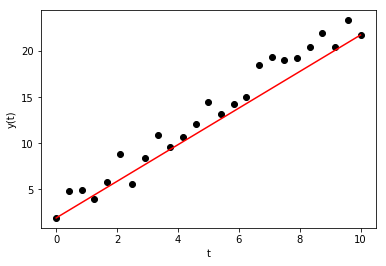

In [2]:
import numpy as np
import matplotlib.pyplot as plt
b = y[0]
a = (y[-1]-y[0])/(t[-1]-t[0])
y_a = a*t + b
plt.plot(t, y, 'ko', t, y_a, 'r')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.show()

## What "Best" Means

To define a "best" line, however, requires we define what "best" means.  In general, any values of $a$ and $b$ will result in a model that differs from the measured values.  This difference is the error.  More formally, let the error be defined as

$$
  e_i = y(t_i) - y_i = a t_i + b - y_i \, \quad i = 0, 1, \ldots
$$

Here, a model provides a best fit if it minimizes the $L_2$ norm of the error, which is defined as

$$
  || \mathbf{e} ||_2 = \sqrt{ |e_0|^2 + |e_1|^2 + \ldots} = \sqrt{\sum_{i=0} |e_i|^2} \, .
$$

Equivalently, such a model is called the **least-squares** fit to the data because the sum of the errors squared is minimized.

For the case of the linear model $y(t) = at + b$, the error can be written in matrix form:

$$
\mathbf{e} = 
\left[
  \begin{matrix} 
    x_0 & 1 \\
    x_1 & 1 \\
    \vdots & 1 \\
    x_{n-1} & 1
   \end{matrix}
\right]
\left[
\begin{matrix}
  a \\
  b 
\end{matrix}
\right] -
\left[
\begin{matrix}
  y_0 \\
  y_1 \\
  \vdots \\
  y_{n-1}
\end{matrix}
\right] \, ,
$$

or $\mathbf{e} = \mathbf{M}\mathbf{c} - \mathbf{y}$.  Here, $\mathbf{M}$ represents the generic data matrix for the model, while $\mathbf{c}$ are the model coefficients that are as yet undetermined.

> **Note**: Generally $\mathbf{M}$ is *not* square and $\mathbf{e}$ is generally not zero.  In other words, rarely can we hope to find $\mathbf{c}$ from $\mathbf{M}^{-1}\mathbf{y}$!  In the example above, we had **25 data points** and just **two unknowns** (the slope $a$ and intercept $b$).  Too many equations means an **overdetermined** system!

Recall that $||\mathbf{e}||_2 = \sqrt{\mathbf{e}^T \mathbf{e}}$, where $T$ represents the matrix transpose.  Moreover, if $a$ and $b$ are found to minimize $\sqrt{\mathbf{e}^T \mathbf{e}}$, then they also minimize $\mathbf{e}^T \mathbf{e}$.  

> **Note**: First, convince yourself $||\mathbf{e}||_2 \geq 0$, i.e., it is nonnegative. Then, convince yourself that any $x$ that minimizes a nonnegative function $f(x)$ also minimizes $f(x)^2$. 

Hence, the best values of $a$ and $b$ minimize the following:

$$
\begin{split}
  \mathbf{e}^T \mathbf{e} 
      &= (\mathbf{M}\mathbf{c} - \mathbf{y})^T (\mathbf{M}\mathbf{c} - \mathbf{y}) \\
      &= \mathbf{c}^T \mathbf{M}^T \mathbf{Mc} - 2 \mathbf{c}^T \mathbf{M}^T \mathbf{y}  + \mathbf{y}^T\mathbf{y} \, .
\end{split}         
$$

Now, remember (e.g., from [Lecture 23](ME400_Lecture_23.ipynb)) that the minimum of a function $f(x)$ (nonlinear or otherwise) can be found when its *derivative* is zero.  In this case, that function is $f(\mathbf{c})$, and the "derivative" is the *gradient* $\nabla ||\mathbf{e}||$.  Thus, differentiation leads to

$$
\nabla \mathbf{e}^T \mathbf{e} = 2 \mathbf{M}^T \mathbf{M} \mathbf{c} - 2\mathbf{M}^T \mathbf{y} = \mathbf{0} \, ,
$$

or

$$
\mathbf{M}^T \mathbf{M} \mathbf{c} = \mathbf{M}^T \mathbf{y} \, .
$$

This equation is often called the [normal equation](http://mathworld.wolfram.com/NormalEquation.html).  The coefficients $\mathbf{c}$ leading to the best fit are defined by

$$
\mathbf{c} = (\mathbf{M}^T \mathbf{M})^{-1}  \mathbf{M}^T \mathbf{y} \, .
$$

Because $\mathbf{M}^T \mathbf{M}$ is square, the system has the same number of equations as it does unknowns.  That alone does not guarantee a solution, but a solution is much more likely.

***
**Exercise**:  Consider the three pairs of points $(1, 1)$, $(2, 1.5)$, $(3, 4.5)$.  Find $a$ and $b$ such that $y(x) = ax+b$ best fits the three points.

*Solution*:

First, define the points:

In [3]:
x = np.array([1, 2, 3])
y = np.array([1, 1.5, 4.5])

Then, define the $3 \times 2$ matrix $\mathbf{M}$:

In [4]:
M = np.array([x, x**0]).T

Finally, solve the system (review [Lecture 4](ME400_Lecture_4.ipynb) for $\mathbf{c}$ and define the approximation for $\mathbf{y}$ via $a\mathbf{x} + b$ (equivalent to $\mathbf{M}\mathbf{c}$). For sanity, plot the result with the original points.

c =  [ 1.75       -1.16666667]


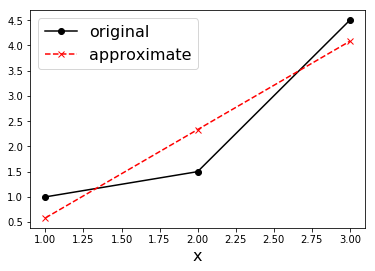

In [5]:
c = np.linalg.solve(M.T.dot(M), M.T.dot(y))
print("c = ", c)
y_a = M.dot(c)
plt.plot(x, y, 'k-o', label='original')
plt.plot(x, y_a, 'r--x', label='approximate')
plt.xlabel('x', fontsize=16)
plt.legend(fontsize=16)
plt.show()

***

**Exercise**:  Compute $\mathbf{e}$ for the last example.  Then, evaluate $\mathbf{e}^T \mathbf{y}_a = \mathbf{e}\cdot \mathbf{y}_a$.

***

**Exercise**: Using pen and paper (or SymPy), convince yourself that $\nabla ||\mathbf{e}||_2$ leads to the normal equation.  (I'll point out this has been a previous exam question.  Hardly worth using a method unless you know how it works.)

***

**Exercise**:  What would $\mathbf{M}$ and $\mathbf{c}$ look like if we wished to fit a set of $(x_i, y_i)$ points to a *quadratic model*?  (Hint, $\mathbf{M}$ should have three columns.)

***

**Exercise**: Sometimes data can be modeled by a simple, linear model after some simple transformations.  Consider the following data, which represents the power of our Kansas State University TRIGA Reactor at $t = 0, 1, \ldots, 10$ seconds upon initiating some experiments: 

```
2.945, 3.964, 4.481, 5.747, 7.523, 8.710, 10.733, 13.910, 16.721, 19.951, 24.610
```

Plot this data and confirm that the power $P$ is *not linear* in time.  However, by inspection, it appears that the *logarithm* of the power *is* linear (which  you should also confirm).  Fit $\log P$ to the model $a t + b$, and then plot $P$ and its approximation from the model versus time.

*Solution*:

First, let's confirm the nonlinearity of $P$ and the linearity of $\log P$:

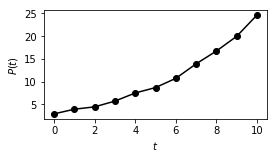

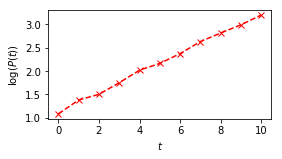

In [6]:
t = np.linspace(0, 10, 11)
P = np.array([2.945, 3.964, 4.481, 5.747, 7.523, 8.710, 10.733, 13.910, 16.721, 19.951, 24.610])
logP = np.log(P)
plt.figure(1, figsize=(4,2))
plt.plot(t, P, 'k-o')
plt.xlabel('$t$'); plt.ylabel('$P(t)$')
plt.figure(2, figsize=(4,2))
plt.plot(t, logP, 'r--x')
plt.xlabel('$t$'); plt.ylabel('$\log(P(t))$')
plt.show()

Now, fit $\log{P}$ to $at + b$:

In [7]:
M = np.array([t, t**0]).T
c = np.linalg.solve(M.T.dot(M), M.T.dot(logP))
logP_a = M.dot(c)

Finally, evaluate $P$ from its logarithm and plot the result against the reference:

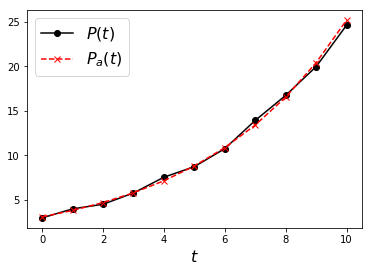

In [8]:
P_a = np.exp(logP_a)
plt.figure(3)
plt.plot(t, P, 'k-o', label='$P(t)$')
plt.plot(t, P_a, 'r--x', label='$P_a(t)$')
plt.xlabel('$t$',fontsize=16)
plt.legend(fontsize=16)
plt.show()

***

**Exercise**:  Inspect the following $(x_i, y_i)$ data:
```
x            y
0.20515647,  0.59102462
0.54550627,  0.84583853
0.59262142,  0.80724061
2.17819173,  1.63791106
3.82397005,  2.10229436
4.88966586,  2.35676675
7.87776356,  2.91240054
8.10359230,  3.03207498
```
Determine a good transformation, and fit the result to $ax + b$.  Apply the inverse transormation, and compare the resulting approximations to the original data.

***

**Exercise**:  How would you 

## Beyond Linear Models

Of course, not all data is intrinsically linear, and we may not be able to apply transformations to make it so.  An alternative is to use higher-order polynomial models of the for $y(x) = a_n x^n + a_{n-1} x^{n-1} +  \ldots + a_0$.  Although this is reasonably straightforward to accomplish by adapting the methods presented above, NumPy has a few built-in functions to simplify the process.

The first of these functions is `np.polyfit`, for which basic use requires three input arguments: `x`, `y`, and `order`.  Here, `x` and `y` correspond to the discrete points to which the polynomial is fitted, and `order` is the highest power of $x$ in the polynomial.  Returned by `np.polyfit` is the array of coefficients $a_n, a_{n-1}, \ldots$ that define the polynomial.

***

**Exercise**: Use `np.polyfit` to reproduce the values of `c` from the three-point exercise above.

*Solution*:

In [9]:
x = np.array([1, 2, 3])
y = np.array([1, 1.5, 4.5])
c = np.polyfit(x, y, 1)
print('c = ', c)

c =  [ 1.75       -1.16666667]


These are the same values computed by solving the normal equations (because `np.polyfit` performs the same least-squares procedure).
***

To evaluate the data, one can use the returned coefficients directly, e.g., `y = c[0]*x + c[1]`.  However, `np.polyval` provides a way to evaluate the resulting model for any value(s) of `x`.  The function `np.polyval` takes just two arguments: the coefficients (i.e., `c`) and the value(s) of `x`.  

***

**Exercise**:  Evaluate $y(x)$ for the previous exercise for `x = [0, 1, 2, 3, 4]`.

*Solution*:


In [10]:
np.polyval(c, [0, 1, 2, 3, 4])

array([-1.16666667,  0.58333333,  2.33333333,  4.08333333,  5.83333333])

***

**Exercise**: Fit the reactor power from above to a cubic function of time.  Plot both the original data and the fitted results.  Produce a second plot with the error as a function of time.

***

**Exercise**:  Consider `x = np.linspace(0, np.pi/2, 100)` and `y = np.cos(x)`.  Fit `y` to polynomials of order 2, 3, 4, and 5.  Produce a second plot with the errors between y and the various models.  (By the way, do the coefficients for the second order look familiar?  Go revisit a past homework.)

***

**Exercise**:  What would $\mathbf{M}$ and $\mathbf{c}$ look like if we wished to fit a set of $(x_i, y_i)$ points to a a model like $a + bx + c\sin(x)$?   (Hint, $\mathbf{M}$ should have three columns.)

***

## Beyond Polynomial Models

Linear models are common, and polynomial models can provide necessary improvements.  For many cases, neither type of model is sufficient.  As an example, consider time-dependent measurements of a process known to be oscillatory but whose parameters (e.g., frequency, phase shift, etc.) are unknown.  Such a model may take the form $y(t) = a\sin(bt + c) + d$.  Such a model can be approximated locally (or within a single period) with polynomials, but such a model hides the physics (as quantified by $a$, $b$, $c$, and/or $d$ in the sinusoidal model).

Built into `scipy.optimize` is the function `curve_fit`, which can be used to determine the coefficients of arbitrary nonlinear models by applying *nonlinear* least squares.  

To dig into `curve_fit`, consider the result of `help(curve_fit)`:

```
Help on function curve_fit in module scipy.optimize.minpack:

curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)
    Use non-linear least squares to fit a function, f, to data.
    
    Assumes ``ydata = f(xdata, *params) + eps``
    
```

Here, `f` must be a function of the form `def func(x, a, b, ...)`, where `x` is the independent variable and `a`, `b`, etc., are the model parameters.  The second and third arguments `xdata` and `ydata` are the independent and dependent variables, respectively, against which the fit is to be made.  Optionally, `p0` is an initial guess for the model parameters.  An initial guess is strongly recommended, since the default value for each is unity, which may be far from a reasonable guess.

As output, `curve_fit` returns two values: (1) the array of best-fit, model coefficients and (2) the covariance of these model coefficients.  For most purposes, only the first return value is needed (just be careful to extract it properly). 


***

**Exercise**: Consider the following data acquired at times $0, 0.1, 0.2, \ldots, 1.0$:

```
1.7222, -0.4074, -0.0098, 0.9937, 3.0986, 3.0519, 2.0899, 0.2276, -0.2550, 0.2815, 2.2938

```
Fit this to the model $y(t) = a\sin(bt + c) + d$ using `curve_fit`.  Plot the best-fit model with the original data.


*Solution*:

First, define the model function:

In [11]:
def model(t, a, b, c, d):
    return a*np.sin(b*t + c) + d

Now, try `curve_fit`:

In [12]:
from scipy.optimize import curve_fit
t = np.linspace(0, 1, 11)
y = np.array([1.7222, -0.4074, -0.0098, 0.9937, 3.0986, 3.0519, 2.0899, 0.2276, -0.2550, 0.2815, 2.2938])
c = curve_fit(model, t, y)[0]
c

array([ 1.88133258, -9.87911136,  6.27749904,  1.45335284])

Finally, use `model` to construct `y_a` using `c` and plot.  In addition to the  original $t$ points, we'll use a much finer set of times to illustrate the continuous model.

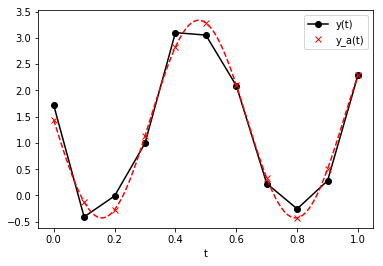

In [13]:
plt.plot(t, y, 'k-o', label='y(t)')
y_a = model(t, c[0], c[1], c[2], c[3])
plt.plot(t, y_a, 'rx', label='y_a(t)')
t_fine = np.linspace(0, 1, 100)
y_a_fine  = model(t_fine, c[0], c[1], c[2], c[3])
plt.plot(t_fine, y_a_fine, 'r--')
plt.xlabel('t')
plt.legend()
plt.show()

***

**Exercise**: Consider the following model and points:

```python
def model(x, a, b, c):
    return a*np.exp(-(x-b)**2/(c**2))
x = np.linspace(0, 5, 100)
y = model(x, 1, 2.5, 2)
y_noisy = y + 0.1 * np.random.normal(size=len(x))
```

Determine $a$, $b$, and $c$ using the `x` and `y_noisy` and plot `y`, `y_noisy`, and `y_model` against `x`.

***

## Further Reading

None for now.